# Loading necessary libraries

In [ ]:
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.losses import sparse_categorical_crossentropy
from keras.layers import (
    Dense, MaxPool2D, AveragePooling2D, Dropout, Flatten,
    Conv2D, Input, Add, BatchNormalization, Activation, Layer
)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model
from keras.datasets import cifar10
import keras.backend as K
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

%load_ext autoreload
%autoreload 2

In [ ]:
class CIFAR10Dataset():
    def __init__(self):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = cifar10.load_data()
        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        print('CIFAR10 training data shape: ', self.x_train.shape)
        print('CIFAR10 training label shape: ', self.y_train.shape)
        print('CIFAR10 test data shape: ', self.x_test.shape)
        print('CIFAR10 test label shape: ', self.y_test.shape)

    def get_data(self, subtract_mean=True):
        num_classes = len(self.classes)
        x_train = self.x_train
        x_test = self.x_test

        x_train = x_train.astype('float16')
        y_train = to_categorical(self.y_train, num_classes)

        x_test = x_test.astype('float16')
        y_test = to_categorical(self.y_test, num_classes)

        if subtract_mean:
            x_train -= np.mean(x_train, axis=0)
            x_test -= np.mean(x_train, axis=0)

        return x_train, y_train, x_test, y_test

In [ ]:
def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1,1)):
    x_new = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay))(x)
    x_new = BatchNormalization()(x_new)
    return x_new

def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1,1)):
    x_new = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    x_new = Activation('relu')(x_new)
    return x_new

In [ ]:
def plain_block(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        stride = 2
    else:
        stride = 1
    x_new = conv2d_bn_relu(x,
                           filters=filters,
                           kernel_size=kernel_size,
                           weight_decay=weight_decay,
                           strides=stride)
    x_new = conv2d_bn(x_new,
                      filters=filters,
                      kernel_size=kernel_size,
                      weight_decay=weight_decay,
                      strides=1)
    out = Activation('relu')(x_new)
    return out

def PlainNet(classes, name, input_shape, block_layers_num, weight_decay):
    input = Input(shape=input_shape)
    x = input

    # Conv 1
    x = conv2d_bn_relu(x,
                       filters=16,
                       kernel_size=(3,3),
                       weight_decay=weight_decay,
                       strides=(1,1))

    # Conv 2
    for i in range(block_layers_num):
        x = plain_block(x,
                        filters=16,
                        kernel_size=(3,3),
                        weight_decay=weight_decay,
                        downsample=False)

    # Conv 3
    x = plain_block(x,
                    filters=32,
                    kernel_size=(3,3),
                    weight_decay=weight_decay,
                    downsample=True)
    for i in range(block_layers_num - 1):
        x = plain_block(x,
                        filters=32,
                        kernel_size=(3,3),
                        weight_decay=weight_decay,
                        downsample=False)

    # Conv 4
    x = plain_block(x,
                    filters=64,
                    kernel_size=(3,3),
                    weight_decay=weight_decay,
                    downsample=True)
    for i in range(block_layers_num - 1):
        x = plain_block(x,
                        filters=64,
                        kernel_size=(3,3),
                        weight_decay=weight_decay,
                        downsample=False)

    # Classifier
    x = AveragePooling2D(pool_size=(8,8), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name=name)
    return model

In [ ]:
def residual_block(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        res_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        res_x = x
        stride = 1
    x_new = conv2d_bn_relu(x,
                           filters=filters,
                           kernel_size=kernel_size,
                           weight_decay=weight_decay,
                           strides=stride)
    x_new = conv2d_bn(x_new,
                      filters=filters,
                      kernel_size=kernel_size,
                      weight_decay=weight_decay,
                      strides=1)
    out = layers.add([res_x, x_new])
    out = Activation('relu')(out)
    return out

def ResNet(classes, name, input_shape, block_layers_num, weight_decay):
    input = Input(shape=input_shape)
    x = input

    # Conv 1
    x = conv2d_bn_relu(x,
                       filters=16,
                       kernel_size=(3,3),
                       weight_decay=weight_decay,
                       strides=(1,1))

    # Conv 2
    for i in range(block_layers_num):
        x = residual_block(x,
                           filters=16,
                           kernel_size=(3,3),
                           weight_decay=weight_decay,
                           downsample=False)

    # Conv 3
    x = residual_block(x,
                       filters=32,
                       kernel_size=(3,3),
                       weight_decay=weight_decay,
                       downsample=True)
    for i in range(block_layers_num - 1):
        x = residual_block(x,
                           filters=32,
                           kernel_size=(3,3),
                           weight_decay=weight_decay,
                           downsample=False)

    # Conv 4
    x = residual_block(x,
                       filters=64,
                       kernel_size=(3,3),
                       weight_decay=weight_decay,
                       downsample=True)
    for i in range(block_layers_num - 1):
        x = residual_block(x,
                           filters=64,
                           kernel_size=(3,3),
                           weight_decay=weight_decay,
                           downsample=False)

    # Classifier
    x = AveragePooling2D(pool_size=(8,8), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name=name)
    return model

In [ ]:
def error_rate(y_true, y_pred):
    # Assuming y_true and y_pred are tensors of the same shape
    incorrect = tf.not_equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1))
    error_rate = tf.reduce_mean(tf.cast(incorrect, tf.float32))
    return error_rate

In [ ]:
class CIFAR10Solver(object):
    def __init__(self, model, data):
        self.model = model
        self.X_train, self.Y_train, self.X_val, self.Y_val, self.X_test, self.Y_test = data

    def __on_epoch_end(self, epoch, logs=None):
        print(K.eval(self.model.optimizer.lr))

    def train(self, epochs=200, batch_size=128, data_augmentation=True, callbacks=None):
        if data_augmentation:
            # datagen
            datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                # rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=4,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=4,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False,  # randomly flip images
            )
            # (std, mean, and principal components if ZCA whitening is applied).
            # datagen.fit(x_train)
            print('train with data augmentation')
            train_gen = datagen.flow(self.X_train, self.Y_train, batch_size=batch_size)
            history = self.model.fit_generator(generator=train_gen,
                                               epochs=epochs,
                                               callbacks=callbacks,
                                               validation_data=(self.X_val, self.Y_val))
        else:
            print('train without data augmentation')
            history = self.model.fit(self.X_train, self.Y_train,
                                     batch_size=batch_size, epochs=epochs,
                                     callbacks=callbacks,
                                     validation_data=(self.X_val, self.Y_val))
        return history

    def test(self):
        loss, acc = self.model.evaluate(self.X_test, self.Y_test)
        print('test data loss:%.2f acc:%.4f' % (loss, acc))

In [ ]:
cifar10_data = CIFAR10Dataset()
x_train, y_train, x_test, y_test = cifar10_data.get_data(subtract_mean=True)

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

# Check shape
print(x.shape) # (60000, 32, 32, 3)

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000, random_state=1234)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000, random_state=1234)

# Check shape
print(x_train.shape) # (45000, 32, 32, 3)

data = (x_train, y_train, x_val, y_val, x_test, y_test)

170498071/170498071 [==============================] - 13s 0us/step
CIFAR10 training data shape:  (50000, 32, 32, 3)
CIFAR10 training label shape:  (50000, 1)
CIFAR10 test data shape:  (10000, 32, 32, 3)
CIFAR10 test label shape:  (10000, 1)
(60000, 32, 32, 3)
(45000, 32, 32, 3)


In [ ]:
weight_decay = 1e-4
lr = 1e-1
num_classes = 10
EPOCHS = 100

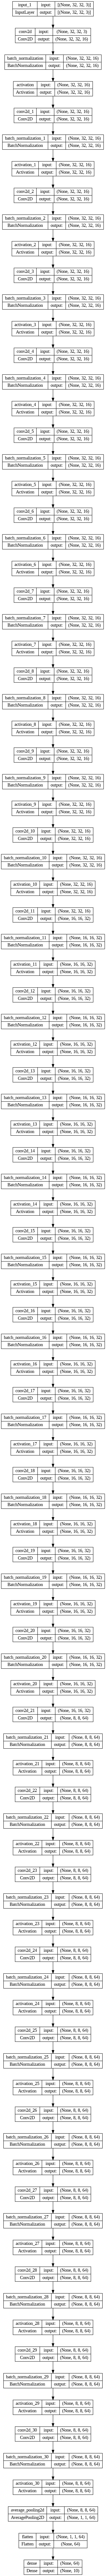

In [ ]:
tf.keras.backend.reset_uids()
plainnet32 = PlainNet(classes=num_classes, name='plainnet32', input_shape=(32, 32, 3), block_layers_num=5, weight_decay=weight_decay)
opt = SGD(lr=lr, momentum=0.9, nesterov=False)
plainnet32.compile(optimizer=opt,
                 loss=keras.losses.categorical_crossentropy,
                 metrics=[error_rate])
# plainnet20.summary()
plot_model(plainnet32, show_shapes=True, expand_nested=True)

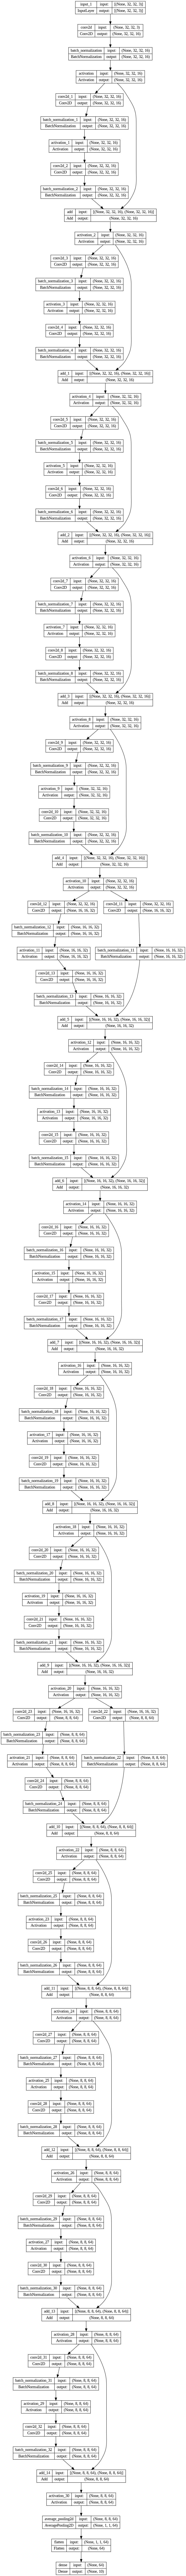

In [ ]:
tf.keras.backend.reset_uids()
resnet32 = ResNet(classes=num_classes, name='resnet32', input_shape=(32, 32, 3), block_layers_num=5, weight_decay=weight_decay)
opt = SGD(lr=lr, momentum=0.9, nesterov=False)
resnet32.compile(optimizer=opt,
                 loss=keras.losses.categorical_crossentropy,
                 metrics=[error_rate])
# resnet20.summary()
plot_model(resnet32, show_shapes=True, expand_nested=True)

In [ ]:
def lr_scheduler(epoch):
    new_lr = lr
    if epoch <= int(0.5*EPOCHS):
        pass
    elif epoch > int(0.5*EPOCHS) and epoch <= int(0.75*EPOCHS):
        new_lr = lr * 0.1
    else:
        new_lr = lr * 0.01
    print('new lr:%.2e' % new_lr)
    return new_lr

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model that outputs the feature maps and final prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        # If pred_index is not specified, use the predicted class index
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalise the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [ ]:
reduce_lr_1 = LearningRateScheduler(lr_scheduler)
mc1 = keras.callbacks.ModelCheckpoint(filepath="plainnet32_cifar10.tf",
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=0,
                                      save_best_only=True)
solver_plain_32 = CIFAR10Solver(plainnet32, data)
history_plain_32 = solver_plain_32.train(epochs=EPOCHS, batch_size=128, data_augmentation=True,
                                         callbacks=[reduce_lr_1, mc1])

train with data augmentation
new lr:1.00e-01
Epoch 1/100


<ipython-input-7-fec8c7b98f6b>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = self.model.fit_generator(generator=train_gen,


352/352 [==============================] - 64s 138ms/step - loss: 2.2744 - error_rate: 0.7704 - val_loss: 3.0923 - val_error_rate: 0.8131 - lr: 0.1000
new lr:1.00e-01
Epoch 2/100
352/352 [==============================] - 58s 163ms/step - loss: 2.0404 - error_rate: 0.6836 - val_loss: 2.6765 - val_error_rate: 0.7526 - lr: 0.1000
new lr:1.00e-01
Epoch 3/100
352/352 [==============================] - 35s 99ms/step - loss: 1.8921 - error_rate: 0.6298 - val_loss: 3.3239 - val_error_rate: 0.8073 - lr: 0.1000
new lr:1.00e-01
Epoch 4/100
352/352 [==============================] - 36s 102ms/step - loss: 1.7493 - error_rate: 0.5695 - val_loss: 2.6852 - val_error_rate: 0.6990 - lr: 0.1000
new lr:1.00e-01
Epoch 5/100
352/352 [==============================] - 36s 101ms/step - loss: 1.5808 - error_rate: 0.5051 - val_loss: 3.3094 - val_error_rate: 0.7002 - lr: 0.1000
new lr:1.00e-01
Epoch 6/100
352/352 [==============================] - 46s 132ms/step - loss: 1.4229 - error_rate: 0.4413 - val_loss: 

In [ ]:
reduce_lr_2 = LearningRateScheduler(lr_scheduler)
mc2 = keras.callbacks.ModelCheckpoint(filepath="resnet32_cifar10.tf",
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=0,
                                      save_best_only=True)
solver_res_32 = CIFAR10Solver(resnet32, data)
history_res_32 = solver_res_32.train(epochs=EPOCHS, batch_size=128, data_augmentation=True,
                                     callbacks=[reduce_lr_2, mc2])

train with data augmentation
new lr:1.00e-01
Epoch 1/100


<ipython-input-7-fec8c7b98f6b>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = self.model.fit_generator(generator=train_gen,


352/352 [==============================] - 56s 135ms/step - loss: 2.1186 - error_rate: 0.7399 - val_loss: 1.9822 - val_error_rate: 0.6775 - lr: 0.1000
new lr:1.00e-01
Epoch 2/100
352/352 [==============================] - 46s 132ms/step - loss: 1.6535 - error_rate: 0.5638 - val_loss: 1.8318 - val_error_rate: 0.5945 - lr: 0.1000
new lr:1.00e-01
Epoch 3/100
352/352 [==============================] - 48s 136ms/step - loss: 1.3192 - error_rate: 0.4251 - val_loss: 1.4662 - val_error_rate: 0.4381 - lr: 0.1000
new lr:1.00e-01
Epoch 4/100
352/352 [==============================] - 46s 132ms/step - loss: 1.0971 - error_rate: 0.3410 - val_loss: 1.1258 - val_error_rate: 0.3424 - lr: 0.1000
new lr:1.00e-01
Epoch 5/100
352/352 [==============================] - 35s 100ms/step - loss: 0.9578 - error_rate: 0.2839 - val_loss: 1.4412 - val_error_rate: 0.4057 - lr: 0.1000
new lr:1.00e-01
Epoch 6/100
352/352 [==============================] - 47s 134ms/step - loss: 0.8662 - error_rate: 0.2498 - val_loss:

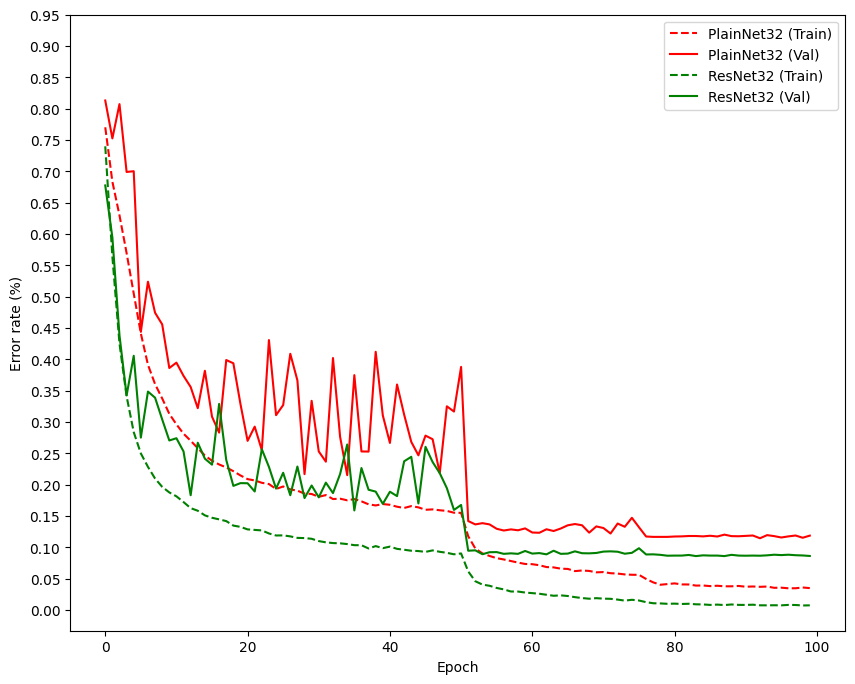

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history_plain_32.history['error_rate'], 'r--', label='PlainNet32 (Train)')
plt.plot(history_plain_32.history['val_error_rate'], 'r-', label='PlainNet32 (Val)')
plt.plot(history_res_32.history['error_rate'], 'g--', label='ResNet32 (Train)')
plt.plot(history_res_32.history['val_error_rate'], 'g-', label='ResNet32 (Val)')

plt.xlabel('Epoch')
plt.ylabel('Error rate (%)')
plt.yticks(np.arange(0, 1, step=0.05))
plt.legend()
plt.show()

In [ ]:
def visualize_results(img_arr, model, layer_names, suptitle=None, figsize=(20,2)):
    fig, axes = plt.subplots(1, len(layer_names) + 1, figsize=figsize)
    axes[0].imshow(img)
    axes[0].set_axis_off()
    idx = 1
    for layer in layer_names:
        heatmap = make_gradcam_heatmap(img_arr, model, layer)
        axes[idx].matshow(heatmap)
        axes[idx].set_axis_off()
        idx += 1
    if suptitle is not None:
        plt.suptitle(suptitle)
    plt.show()

In [ ]:
img = np.mean(x_test, axis=0).astype('uint8')
img_arr = img.reshape((1,32,32,3))

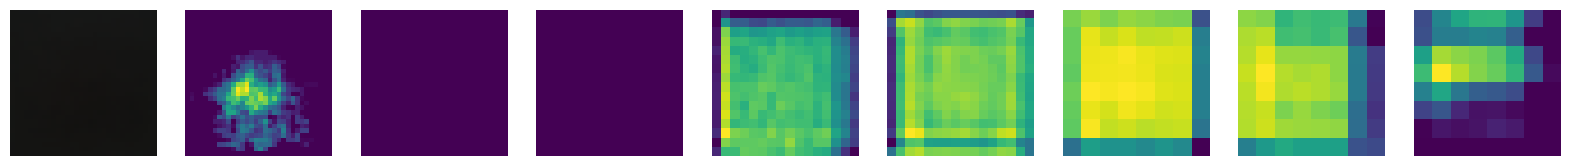

In [ ]:
plainnet32.load_weights("plainnet32_cifar10.tf")
visualize_results(img_arr, model=plainnet32,
                  layer_names=['conv2d', 'conv2d_10', 'conv2d_11', 'conv2d_12',
                               'conv2d_20', 'conv2d_21', 'conv2d_22', 'conv2d_30'])

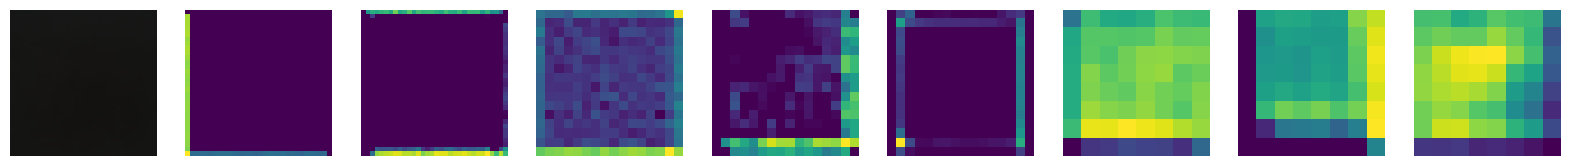

In [ ]:
resnet32.load_weights("resnet32_cifar10.tf")
visualize_results(img_arr, model=resnet32,
                  layer_names=['conv2d', 'conv2d_10', 'conv2d_12', 'conv2d_13',
                               'conv2d_21', 'conv2d_23', 'conv2d_24', 'conv2d_32'])